In [91]:
import GN_ode as gn
import numpy as np
from scipy.integrate import odeint, solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as LA

## Newton's method
Solve $\mathbf{f}''(\mathbf{x})\mathbf{h}=-\mathbf{f'(x)}$

In [132]:
def ex1(x):
    return 0.5*x[0]**2*(x[0]**2/6+1)+x[1]*np.arctan(x[1])-0.5*np.log(x[1]**2+1)
def d1ex1(x):
    r1 = x[0]**3/3+x[0]
    r2 = np.arctan(x[1])
    return np.array([r1,r2])
def d2ex1(x):
    r11 = x[0]**2+1
    r22 = 1/(1+x[1]**2)
    return np.array([[r11,0],[0,r22]])

In [143]:
def newton(x):
    iter = 0
    f = ex1(x)
    d1n = LA.norm(d1ex1(x))
    hn = 0
    while iter<=5:
        iter += 1
        print(*[x,f,d1n,hn])
        h = LA.solve(d2ex1(x),-d1ex1(x))
        x = x + h
        f = ex1(x)
        d1n = LA.norm(d1ex1(x))
        hn = LA.norm(h)
    return x

In [144]:
x = newton([1,0.7])

[1, 0.7] 0.8114534484270954 1.466548322203161 0
[ 0.33333333 -0.20998169] 0.07847129726922965 0.4029050598080402 1.1280563438988624
[0.02222222 0.00611896] 0.00026565460930539394 0.02305277561832044 0.3788002273222916
[ 7.3123469e-06 -1.5273477e-07] 2.6746879144831864e-11 7.3139418280887725e-06 0.023042259817480305
[2.60662531e-16 2.38228016e-21] 3.397247755400034e-32 2.606625310671356e-16 7.313941827697864e-06
[0. 0.] 0.0 0.0 2.606625310671356e-16


In [145]:
x = newton([1,2])

[1, 2] 1.992911812704464 1.7330770499579284 0
[ 0.33333333 -3.53574359] 3.334570302914684 1.340506199335136 5.575742240031537
[ 0.02222222 13.95095909] 18.277958953041583 1.499403790524476 17.489469991932662
[ 7.31234690e-06 -2.79344067e+02] 432.16018725172415 1.5672165273884322 293.2950264618516
[2.60662531e-16 1.22016999e+05] 191651.14179121036 1.5707881312155196 122296.3429844881
[ 0.00000000e+00 -2.33860042e+10] 36734649467.649124 1.570796326752136 23386126214.93277


## Levenberg-Marquardt method

In [181]:
def lm(func,d1,d2,x,opts=[1e-3,1e-8,1e-8,1000]):
    p = np.size(x)
    I = np.eye(p)
    nu = 2
    mu = opts[0]
    f0 = func(x)
    found = False
    iter = 0
    H = d2(x)
    g = d1(x)
    while not found:
        iter += 1
        h = LA.solve(H+mu*I,-g)
        xn = LA.norm(x,2)
        hn = LA.norm(h,2)
        if hn <= opts[2]*(xn+opts[2]):
            found = True
        else:
            xnew = x + h
            f = func(xnew)
            rho = (f0-f)/(-h@g-h@H@h/2)
            if rho>1e-3:
                x = xnew
                f0 = f
                H = d2(x)
                g = d1(x)
                gn = LA.norm(g,np.inf)
                found = bool(gn<=opts[1])
                mu *= max(1/3,1-(2*rho-1)**3)
                nu = 2
            else:
                mu *= nu
                nu *= 2
        print(*[iter,x,f,gn,rho,mu])
    return x    

In [182]:
x0 = [1,2]

In [183]:
res = lm(ex1,d1ex1,d2ex1,x0,[1,1e-8,1e-12,10])

1 [0.55555556 1.07737607] 0.6633138106211669 0.8226279732113916 0.9986314333678693 0.3333333333333333
2 [0.18240045 0.04410287] 0.01769941831974399 0.18442326178999555 0.8719008911702721 0.19616609671433488
3 [0.03239405 0.00719666] 0.000550674855304072 0.032405384442749874 1.009563547686992 0.06538869890477829
4 [0.00200749 0.00044149] 2.1124712707302104e-06 0.0020074960355820994 1.0004219158888992 0.02179623296825943
5 [4.28275345e-05 9.41742288e-06] 9.614427360237247e-10 4.282753451115148e-05 1.0000018110439293 0.00726541098941981
6 [3.08915295e-07 6.79279228e-08] 4.9997064067420426e-14 3.089152949211551e-07 0.9999999782375907 0.0024218036631399363
7 [7.46324741e-10 1.64110649e-10] 3.0543261439581334e-19 7.463247408682824e-10 0.9995125967183283 0.0008072678877133121


In [184]:
res

array([7.46324741e-10, 1.64110649e-10])

# Fitting  model
$$M(\mathbf{x},t)=x_3e^{x_1t}+x_4e^{x_2t}$$
## Measurements

In [50]:
df = pd.read_csv("efit1.dat",delimiter=' ',header=None)

In [54]:
t = np.array(df[3])
yhat = np.array(df[7])

## Least squares
$$f_i(\mathbf{x})=y_i-M(\mathbf{x},t_i)$$
$$F(\mathbf{x})=\frac{1}{2}\sum_{i=1}^mf_i(\mathbf{x})^2$$
## Jacobian
$$\left(\mathbf{J}(\mathbf{x})\right)_{ij}=\frac{\partial f_i}{\partial x_j}(\mathbf{x})$$
$$\mathbf{J}(\mathbf{x})_i=\begin{bmatrix}-x_3t_ie^{x_1t_i}&-x_4t_ie^{x_2t_i}&-e^{x_1t_i}&-e^{x_2t_i}\end{bmatrix}$$

In [174]:
def ex2(x,t):    
    return x[2]*np.exp(x[0]*t)+x[3]*np.exp(x[1]*t)

def Jex2(x,t):
    j1 = -x[2]*t*np.exp(x[0]*t)
    j2 = -x[3]*t*np.exp(x[1]*t)
    j3 = -np.exp(x[0]*t)
    j4 = -np.exp(x[1]*t)
    return np.array([j1,j2,j3,j4])

In [175]:
def Hg(func,J,yhat,x,t):
    m = func(x,t)
    f = yhat-m
    J = J(x,t).T
    H = J.T@J
    g = J.T@f
    return H, g

In [180]:
def F(func,yhat,x,t):
    m = func(x,t)
    f = yhat-m
    return np.dot(f,f)/2

## Gauss-Newton method
$$\mathbf{H=J^\top J}$$
$$\mathbf{g=J^\top f}$$
Solve
$$\mathbf{Hh=-g}$$

In [191]:
def gn(func,J,yhat,x,t,opts=[1e-8,1e-8,1000]):
    found = False
    iter = 0
    S = F(func,yhat,x,t)
    H,g = Hg(func,J,yhat,x,t)
    gn = LA.norm(g,np.inf)
    while not found:
        iter += 1
        h = LA.solve(H,-g)
        xn = LA.norm(x,2)
        hn = LA.norm(h,2)
        if hn <= opts[1]*(xn+opts[1]):
            found = True
        else:
            x += h
            S = F(func,yhat,x,t)
            H,g = Hg(func,J,yhat,x,t)
            gn = LA.norm(g,np.inf)
            found = bool(gn<=opts[0])
        print(*[iter,x,S,gn])
    return x

In [196]:
x = np.array([-4,-5,4,-4])
x0 = [-3,-6,3,-3]

In [198]:
res = gn(ex2,Jex2,yhat,x0,t,[1e-8,1e-8,10])

1 [-3.2577303  -5.77198388  1.82515609 -1.82567999] 0.04056132808533103 0.5488055801536558
2 [-3.67075968 -5.35515906  2.19597004 -2.19611385] 0.010384311948224676 0.21606653723870717
3 [-3.94519986 -5.05437361  3.12462439 -3.12458962] 0.02420654641808777 0.37123418711582584
4 [-4.00299501 -4.99774073  3.92878432 -3.92878744] 0.005587530407932267 0.06368190365243927
5 [-4.00035739 -4.99948182  4.00377927 -4.00377686] 0.0049999847494690474 0.00023523610982514181
6 [-3.99997651 -5.00003353  3.99977338 -3.99977335] 0.004999976484523449 2.5662580767082943e-06
7 [-4.00003262 -4.99995618  4.0003014  -4.00030094] 0.004999976483464079 4.84431537453589e-08
8 [-4.00002596 -4.99996541  4.00023907 -4.00023867] 0.004999976483462053 8.58306523077168e-10


In [85]:
F(model,yhat,x,t)

0.009999952967396152

## LM method

In [241]:
def lmls(func,J,yhat,x,t,opts=[1e-3,1e-8,1e-8,1000]):
    p = np.size(x)
    I = np.eye(p)
    nu = 2
    tau = opts[0]
    found = False
    iter = 0
    S = F(func,yhat,x,t)
    S0 = S
    H,g = Hg(func,J,yhat,x,t)
    gn = LA.norm(g,np.inf)
    mu = tau*max(np.diag(H))
    rho = 0
    sl = np.array(S)
    gl = np.array(gn)
    ml = np.array(mu)
    while not found:
        iter += 1
        h = LA.solve(H+mu*I,-g)
        xn = LA.norm(x,2)
        hn = LA.norm(h,2)
        if hn <= opts[2]*(xn+opts[2]):
            found = True
        else:
            xnew = x + h
            S = F(func,yhat,xnew,t)
            rho = (S0-S)/(h@(mu*h-g)/2)
            if rho>1e-3:
                x = xnew
                S0 = S
                H,g = Hg(func,J,yhat,x,t)
                gn = LA.norm(g,np.inf)
                found = bool(gn<=opts[1])
                mu *= max(1/3,1-(2*rho-1)**3)
                nu = 2
            else:
                mu *= nu
                nu *= 2
        sl = np.append(sl,S)
        gl = np.append(gl,gn)
        ml = np.append(ml,mu)
        print(*[iter,x,S,gn,rho,mu])
    return x,iter,sl,gl,ml  

In [242]:
x0 = [-1,-2,1,-1]
x,iter,sl,gl,ml= lmls(ex2,Jex2,yhat,x0,t,[1e-3,1e-8,1e-8,10])

1 [-2.02342935 -2.93693615  1.16558548 -0.9581262 ] 0.07161240420829074 0.24765601129333512 0.9097512506455863 0.009196365333931731
2 [-2.84934258 -4.44390339  1.42347592 -1.26377012] 0.028178259180255273 0.06300193941990175 1.0662410302516978 0.003065455111310577
3 [-3.43605714 -5.67887259  1.73036326 -1.69574809] 0.006191788114826111 0.08099111755129651 1.0001546321655428 0.001021818370436859
4 [-3.50234509 -5.79896727  1.79259424 -1.79675018] 0.005033825320850841 0.002347658384651563 0.9987740518301147 0.000340606123478953
5 [-3.54303572 -5.73005336  1.8749221  -1.87943948] 0.005031260669297913 0.006730069462029097 0.32022971533347483 0.00035643667905990706
6 [-3.57045954 -5.67914268  1.94199264 -1.94612684] 0.005023506146219912 0.0038892795311592093 0.8030649928995907 0.0002770624176541125
7 [-3.59905113 -5.62651491  2.0147563  -2.01849358] 0.005020061720791249 0.0043546582787797085 0.5915075223423597 0.00027536402541662535
8 [-3.62190422 -5.58563572  2.07747778 -2.08091954] 0.0050

In [244]:
x = np.linspace(0,iter,iter+1)

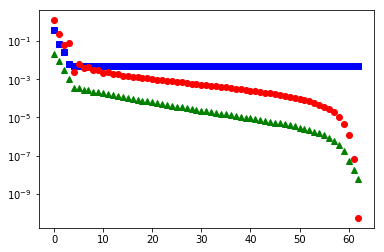

In [245]:
plt.plot(x,sl,'bs')
plt.yscale('log')
plt.plot(x,gl,'ro')
plt.plot(x,ml,'g^')